# 浣熊 (Racoon) 物體偵測 -使用訓練完成的YOLOv2模型

在進行這個Jupyter Notebook之前, 請先完成浣熊YOLOv2模型的訓練。

詳細步驟: [3.2: 浣熊 (Racoon)偵測-YOLOv2模型訓練與調整](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/3.2-yolov2-train_racoon_dataset.ipynb)

![raccoon](https://cdn-images-1.medium.com/max/800/1*bSs_IXHpMbDqinfcWGRRfg.jpeg)

### STEP 1. 載入相關函式庫

In [1]:
# Utilities相關函式庫
import os
import random
from tqdm import tqdm

# 多維向量處理相關函式庫
import numpy as np

# 圖像處理相關函式庫
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 序列/反序列化相關函式庫
import pickle

# 深度學習相關函式庫
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K
import tensorflow as tf

# 專案相關函式庫
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_bgr_image_boxes, normalize

Using TensorFlow backend.


#### 設定相關設定與參數

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 資料集目錄
DATA_SET_PATH = os.path.join(DATA_PATH, "raccoon")

# 資料集標註檔目錄
ANNOTATIONS_PATH = os.path.join(DATA_SET_PATH, "annotations")

# 資料集圖像檔目錄
IMAGES_PATH = os.path.join(DATA_SET_PATH, "images")

#### 定義圖像的類別

In [3]:
# 圖像類別的Label-encoding
map_classes = {0: 'raccoon'} # 注意！ 圖像的類別名稱要與標註圖裡的資訊相符

# 取得所有圖像的圖像類別列表
labels=list(map_classes.values())

print(labels)

['raccoon']


#### 設定YOLOv2模型的設定與參數

In [4]:
LABELS = labels

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.001
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

### STEP 2. 構建YOLOv2網絡結構模型

In [5]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [6]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

## 圖像的物體偵測

In [7]:
# 載入訓練好的模型權重
model.load_weights("weights_raccoon.h5")

In [8]:
# 產生一個Dummy的標籤輸入

# 在訓練階段放的是真實的邊界框與圖像類別訊息
# 但在預測階段還是需要有一個Dummy的輸入, 因為定義在網絡的結構中有兩個輸入： 
#   1.圖像的輸人 
#   2.圖像邊界框/錨點/信心分數的輸入
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

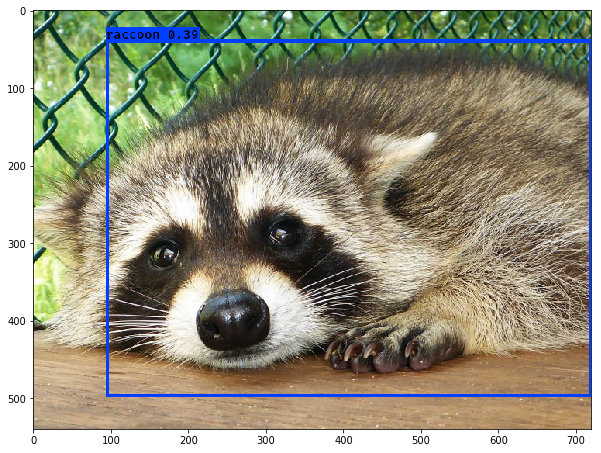

In [9]:
# 選一張圖像
img_filepath = os.path.join(IMAGES_PATH,"raccoon-20.jpg")

# 使用OpenCV讀入圖像
image = cv2.imread(img_filepath)

plt.figure(figsize=(10,10))

# 進行圖像輸入的前處理
input_image = cv2.resize(image, (416,416)) # 修改輸入圖像大小來符合模型的要求
input_image = input_image / 255. # 進行圖像歸一處理
input_image = np.expand_dims(input_image, 0) # 增加 batch dimension

# 進行圖像偵測
netout = model.predict([input_image, dummy_array]) 

# 解析網絡的輸出來取得最後偵測出來的邊界框(bounding boxes)列表
boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      #obj_threshold=0.3,
                      nms_threshold=NMS_THRESHOLD,
                      #nms_threshold=0.001,
                      anchors=ANCHORS, 
                      nb_class=CLASS)

# "draw_bgr_image_boxes"
# 一個簡單把邊界框與預測結果打印到原始圖像(BGR)上的工具函式
# 參數: image 是image的numpy ndarray [h, w, channels(BGR)]
#       boxes 是偵測的結果
#       labels 是模型訓練的圖像類別列表
# 回傳： image 是image的numpy ndarray [h, w, channels(RGB)]
image = draw_bgr_image_boxes(image, boxes, labels=LABELS)

# 把最後的結果秀出來
plt.imshow(image)
plt.show()

**Random images test**

In [10]:
from glob import glob
images = glob(IMAGES_PATH+'/*jpg')

/home/share/John/Deeplearning_nb/basic-yolo-keras/data/raccoon/images/raccoon-121.jpg


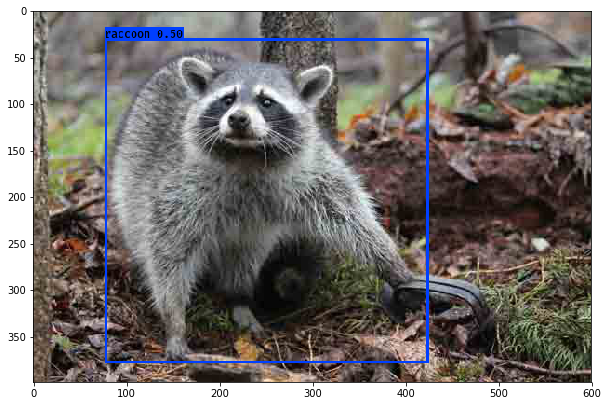

In [16]:
# 選一張圖像
img_filepath = images[random.randint(0, len(images))]

#img_filepath = 'D:\\pythonworks\\01_erhwen\\basic-yolo-keras\\data\\raccoon\\images\\raccoon-6.jpg'
print(img_filepath)

# 使用OpenCV讀入圖像
image = cv2.imread(img_filepath)

plt.figure(figsize=(10,10))

# 進行圖像輸入的前處理
input_image = cv2.resize(image, (416, 416)) # 修改輸入圖像大小來符合模型的要求
input_image = input_image / 255. # 進行圖像歸一處理
input_image = np.expand_dims(input_image, 0) # 增加 batch dimension

# 進行圖像偵測
netout = model.predict([input_image, dummy_array]) 

# 解析網絡的輸出來取得最後偵測出來的邊界框(bounding boxes)列表
boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      #obj_threshold=0.3,
                      nms_threshold=NMS_THRESHOLD,
                      #nms_threshold=0.001,
                      anchors=ANCHORS, 
                      nb_class=CLASS)

# "draw_bgr_image_boxes"
# 一個簡單把邊界框與預測結果打印到原始圖像(BGR)上的工具函式
# 參數: image 是image的numpy ndarray [h, w, channels(BGR)]
#       boxes 是偵測的結果
#       labels 是模型訓練的圖像類別列表
# 回傳： image 是image的numpy ndarray [h, w, channels(RGB)]
image = draw_bgr_image_boxes(image, boxes, labels=LABELS)

# 把最後的結果秀出來
plt.imshow(image)
plt.show()

## 影像的物體偵測

In [ ]:
# 載入訓練好的模型權重
model.load_weights("weights_racoon.h5")

In [ ]:
# 產生一個Dummy的標籤輸入

# 在訓練階段放的是真實的邊界框與圖像類別訊息
# 但在預測階段還是需要有一個Dummy的輸入, 因為定義在網絡的結構中有兩個輸入： 
#   1.圖像的輸人 
#   2.圖像邊界框/錨點/信心分數的輸入

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

In [10]:
# 選擇要進行浣熊影像偵測的影像檔
# 在這個測試我從YOUTUBE下載了: https://www.youtube.com/watch?v=c0IykwK6zkY
video_inp = os.path.join(DATA_SET_PATH, "racoon.mp4")

# 偵測結果的輸出影像檔
video_out = os.path.join(DATA_SET_PATH, "racoon_yolov2.mp4")

# 透過OpenCv擷取影像
video_reader = cv2.VideoCapture(video_inp)

# 取得影像的基本資訊
nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # 總共有多少frames
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))  # 每個frame的高
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))   # 每個frame的寬

# 設定影像的輸出
video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), # 定義codec
                               50.0, 
                               (frame_w, frame_h))

# 迭代每一個frame來進行圖像偵測
for i in tqdm(range(nb_frames)):
    ret, image = video_reader.read() # 讀取一個frame
    input_image = cv2.resize(image, (416, 416)) # 修改輸入圖像大小來符合模型的要求
    input_image = input_image / 255. # 進行圖像歸一處理
    input_image = np.expand_dims(input_image, 0) # 增加 batch dimension
    
    # 進行圖像偵測
    netout = model.predict([input_image, dummy_array])

    # 解析網絡的輸出來取得最後偵測出來的邊界框(bounding boxes)列表
    boxes = decode_netout(netout[0], 
                          obj_threshold=OBJ_THRESHOLD,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    
    # "draw_bgr_image_boxes"
    # 一個簡單把邊界框與預測結果打印到原始圖像(BGR)上的工具函式
    # 參數: image 是image的numpy ndarray [h, w, channels(BGR)]
    #       boxes 是偵測的結果
    #       labels 是模型訓練的圖像類別列表
    # 回傳： image 是image的numpy ndarray [h, w, channels(RGB)]
    image = draw_bgr_image_boxes(image, boxes, labels=LABELS)
    
    # 透過OpenCV把影像輸出出來
    video_writer.write(np.uint8(image[:,:,::-1])) # 轉換 RGB -> BGR來讓Open CV寫Video
    
video_reader.release() # 釋放資源
video_writer.release() # 釋放資源

0it [00:00, ?it/s]


### 轉換後的結果:

[YOUTUBE-raccoon](https://youtu.be/Yb-sEcZPrpM)

In [13]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/Yb-sEcZPrpM?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

參考:
* [YOLO官網](https://pjreddie.com/darknet/yolo/)
* [llSourcell/YOLO_Object_Detection](https://github.com/llSourcell/YOLO_Object_Detection)
* [experiencor/basic-yolo-keras](https://github.com/experiencor/basic-yolo-keras)
* [experiencor/raccoon_dataset](https://github.com/experiencor/raccoon_dataset)
* [how to train your own object detector](https://towardsdatascience.com/how-to-train-your-own-object-detector-with-tensorflows-object-detector-api-bec72ecfe1d9)